# 3.1 Adapting to Real Predictions

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from math import sqrt
from statistics import mean
from collections import Counter

We begin by importing the data and metadata we saved on project #1 and exporting vocabularies:

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)[['user','movie','rating']]
test_df = pd.read_csv('../local_data/test_data.csv', header=0)[['user','movie','rating']]
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]

Converting to datasets:

In [4]:
def convert_to_dataset(df):
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d = {k:(np.expand_dims(v, axis=1) if k != 'user' else v) for k,v in d.items()}  # expanding dimensions of movie and rating features
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_df)
test_dataset = convert_to_dataset(test_df)

2022-02-02 22:42:05.921888: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Below is the model design of milestone #2.2, but this time, note that the shape of `movie_input` has an additional dimension. As a result, the `towers_multiplied` layer requires a creaful handling.

In [5]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        # User tower
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, 25, name='user_emb')(self.user_sl), axis=1)
        self.user_dense = tf.keras.layers.Dense(20, activation='relu', name='user_dense')(self.user_emb)
        
        # Movie tower
        self.movie_input = tf.keras.Input(shape=(None,1), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, 25, name='movie_emb')(self.movie_sl), axis=2)
        self.movie_dense = tf.keras.layers.Dense(20, activation='relu', name='movie_dense')(self.movie_emb)
        
        # Merging towers
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([tf.expand_dims(self.user_dense, axis=2), 
                                                                                     tf.transpose(self.movie_dense, perm=[0,2,1])])  # the 0-axis is the batch size, and it must always remain the first dimension.
        self.towers_dense = tf.keras.layers.Dense(10, activation='relu', name='towers_dense')(tf.transpose(self.towers_multiplied, perm=[0,2,1]))
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense)
        
        # Model definition
        self.model = tf.keras.Model(inputs={'user': self.user_input, 
                                            'movie': self.movie_input}, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'user': tf.strings.as_string(features["user"]),
                           'movie': tf.strings.as_string(features["movie"])})
    
    def compute_loss(self, features_dict, training=False):
        labels = features_dict["rating"]
        predictions = self(features_dict)
        return self.task(labels=labels, predictions=predictions)

Training and evaluating:

In [6]:
model = RatingPredictionModel()
learning_rate = 2e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=5)
model.fit(cached_train, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000


2022-02-02 22:48:00.021888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


96/96 [==============================] - 6s 51ms/step - root_mean_squared_error: 2.8754 - loss: 8.1221 - regularization_loss: 0.0000e+00 - total_loss: 8.1221
Epoch 2/1000
96/96 [==============================] - 1s 9ms/step - root_mean_squared_error: 1.0119 - loss: 1.0223 - regularization_loss: 0.0000e+00 - total_loss: 1.0223
Epoch 3/1000
96/96 [==============================] - 1s 9ms/step - root_mean_squared_error: 0.9713 - loss: 0.9428 - regularization_loss: 0.0000e+00 - total_loss: 0.9428
Epoch 4/1000
96/96 [==============================] - 1s 9ms/step - root_mean_squared_error: 0.9653 - loss: 0.9312 - regularization_loss: 0.0000e+00 - total_loss: 0.9312
Epoch 5/1000
96/96 [==============================] - 1s 9ms/step - root_mean_squared_error: 0.9645 - loss: 0.9295 - regularization_loss: 0.0000e+00 - total_loss: 0.9295
Epoch 6/1000
96/96 [==============================] - 1s 10ms/step - root_mean_squared_error: 0.9632 - loss: 0.9268 - regularization_loss: 0.0000e+00 - total_loss

In [7]:
cached_test = test_dataset.batch(5000).cache()
model.evaluate(cached_test, return_dict=True)

11/11 [==============================] - 0s 15ms/step - root_mean_squared_error: 0.9231 - loss: 0.9275 - regularization_loss: 0.0000e+00 - total_loss: 0.9275


{'root_mean_squared_error': 0.9231146574020386,
 'loss': 1.304904818534851,
 'regularization_loss': 0,
 'total_loss': 1.304904818534851}

We've reached $RMSE = 0.92$.

We'll now plot and save the model.

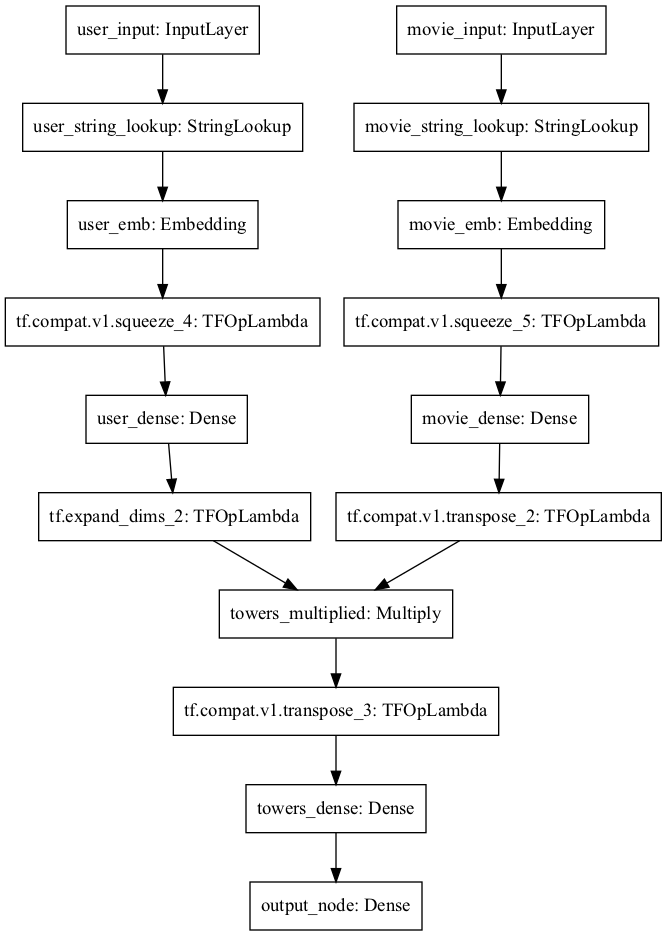

In [8]:
tf.keras.utils.plot_model(model.model, to_file="project_3_1.png")

In [9]:
model.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
user_string_lookup (StringLooku (None, 1)            0           user_input[0][0]                 
__________________________________________________________________________________________________
movie_string_lookup (StringLook (None, None, 1)      0           movie_input[0][0]                
____________________________________________________________________________________________

In [10]:
model.save_weights('weights_3_1/p31')